
# Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
import h5py
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import soundfile 

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/Dataset/Ravdess/audio_speech_actors_01-24/"
Tess = "/content/drive/MyDrive/Dataset/Tess/"
Savee = "/content/drive/MyDrive/Dataset/Ravdess/Savee/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/Dataset/Ravdess/audio_s...
1,sad,/content/drive/MyDrive/Dataset/Ravdess/audio_s...
2,neutral,/content/drive/MyDrive/Dataset/Ravdess/audio_s...
3,happy,/content/drive/MyDrive/Dataset/Ravdess/audio_s...
4,fear,/content/drive/MyDrive/Dataset/Ravdess/audio_s...


In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/Tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
## Create a dataframe
Tess_df = pd.DataFrame()
Tess_df['Emotions'] = labels
Tess_df['Path'] = paths
Tess_df['Emotions'].replace({'ps':'surprise'},inplace = True)
Tess_df.head()


,Emotions,Path
0,surprise,/content/drive/MyDrive/Dataset/Tess/YAF_pleasa...
1,surprise,/content/drive/MyDrive/Dataset/Tess/YAF_pleasa...
2,surprise,/content/drive/MyDrive/Dataset/Tess/YAF_pleasa...
3,surprise,/content/drive/MyDrive/Dataset/Tess/YAF_pleasa...
4,surprise,/content/drive/MyDrive/Dataset/Tess/YAF_pleasa...


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/Dataset/Ravdess/Savee/D...
1,angry,/content/drive/MyDrive/Dataset/Ravdess/Savee/D...
2,angry,/content/drive/MyDrive/Dataset/Ravdess/Savee/D...
3,angry,/content/drive/MyDrive/Dataset/Ravdess/Savee/D...
4,angry,/content/drive/MyDrive/Dataset/Ravdess/Savee/D...


In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df,Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/Dataset/Ravdess/audio_s...
1,sad,/content/drive/MyDrive/Dataset/Ravdess/audio_s...
2,neutral,/content/drive/MyDrive/Dataset/Ravdess/audio_s...
3,happy,/content/drive/MyDrive/Dataset/Ravdess/audio_s...
4,fear,/content/drive/MyDrive/Dataset/Ravdess/audio_s...


# Data Exploration and Visualisation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


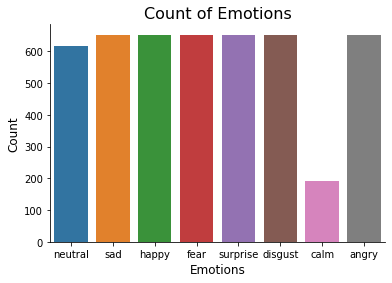

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
data_path.Emotions.value_counts()

sad         652
happy       652
fear        652
surprise    652
disgust     652
angry       652
neutral     616
calm        192
Name: Emotions, dtype: int64

In [ ]:
data_path.shape

(4720, 2)

# Exploratory Data Analysis

Data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# Feature Extraction

In [ ]:
def extract_features(data):
     with soundfile.SoundFile(file) as sound_file:
        data = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        # ZCR
        result = np.array([])
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
        result=np.hstack((result, zcr)) # stacking horizontally

        # Chroma_stft
        stft = np.abs(librosa.stft(data))
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_stft)) # stacking horizontally

        # MFCC
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mfcc)) # stacking horizontally

        # Root Mean Square Value
        rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
        result = np.hstack((result, rms)) # stacking horizontally

        # MelSpectogram
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel)) # stacking horizontally
        
        return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

## Saving the features into csv format so that we dont have to extract features again and again.

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

# Data Preparation

In [ ]:
# Features = pd.read_csv('/content/drive/MyDrive/features.csv')
# Features.shape

(14160, 163)

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(np.array(X),Y, test_size=0.25, random_state=69)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162), (10620,), (3540, 162), (3540,))

In [ ]:
y_test

array(['sad', 'neutral', 'happy', ..., 'fear', 'disgust', 'angry'],
      dtype=object)

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

making our data compatible to model.

In [ ]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

In [ ]:
x_train.shape

(10620, 162, 1)

# CNN model

In [ ]:
model_cnn= Sequential()
model_cnn.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='elu', input_shape=(x_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_cnn.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='elu'))
model_cnn.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_cnn.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='elu'))
model_cnn.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='elu'))
model_cnn.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_cnn.add(Flatten())
model_cnn.add(Dense(units=32, activation='elu'))
model_cnn.add(Dropout(0.2))

model_cnn.add(Dense(units=8, activation='softmax'))
model_cnn.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

# Training the model

In [ ]:
history=model_cnn.fit(x_train, y_train, batch_size=32, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
332/332 [==============================] - 7s 10ms/step - loss: 1.2490 - accuracy: 0.5521 - val_loss: 0.9263 - val_accuracy: 0.6619
Epoch 2/150
332/332 [==============================] - 3s 8ms/step - loss: 0.8987 - accuracy: 0.6787 - val_loss: 0.7511 - val_accuracy: 0.7333
Epoch 3/150
332/332 [==============================] - 3s 8ms/step - loss: 0.7821 - accuracy: 0.7167 - val_loss: 0.7193 - val_accuracy: 0.7328
Epoch 4/150
332/332 [==============================] - 2s 7ms/step - loss: 0.7107 - accuracy: 0.7422 - val_loss: 0.6968 - val_accuracy: 0.7427
Epoch 5/150
332/332 [==============================] - 2s 7ms/step - loss: 0.6516 - accuracy: 0.7630 - val_loss: 0.6036 - val_accuracy: 0.7831
Epoch 6/150
332/332 [==============================] - 3s 8ms/step - loss: 0.6057 - accuracy: 0.7776 - val_loss: 0.5988 - val_accuracy: 0.7771
Epoch 7/150
332/332 [==============================] - 2s 7ms/step - loss: 0.5690 - accuracy: 0.7905 - val_loss: 0.5793 - val_accuracy: 0.783

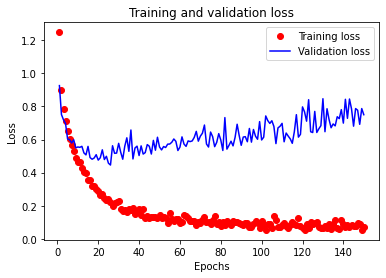

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

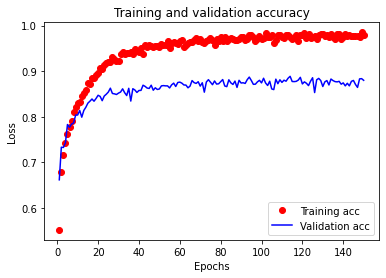

In [ ]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model_cnn.save('model_cnn.h5')
loaded_model= tf.keras.models.load_model('model_cnn.h5')

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 87.99%


In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

111/111 [==============================] - 0s 2ms/step


In [ ]:
preds

array([[1.0650574e-33, 6.3277954e-22, 1.1802608e-26, ..., 6.4665487e-29,
        1.0000000e+00, 1.1463957e-31],
       [2.0721650e-26, 1.7158771e-23, 4.3776640e-18, ..., 1.0000000e+00,
        5.4157422e-19, 1.2777766e-29],
       [8.6610287e-13, 7.6973788e-27, 7.3148616e-19, ..., 2.2029985e-27,
        3.9860733e-19, 8.3298406e-19],
       ...,
       [1.4579634e-03, 6.9662323e-04, 2.4870121e-01, ..., 1.3170534e-05,
        3.6646376e-04, 3.9545172e-03],
       [1.1308591e-16, 4.5288167e-21, 1.0000000e+00, ..., 4.0162663e-18,
        3.5969115e-14, 5.3201363e-12],
       [1.0000000e+00, 0.0000000e+00, 2.1369831e-31, ..., 0.0000000e+00,
        2.3954869e-34, 8.1381674e-23]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,sad
1,neutral
2,happy
3,fear
4,sad
5,surprise
6,sad
7,fear
8,disgust
9,neutral


In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,sad
1,neutral
2,happy
3,happy
4,sad
5,surprise
6,sad
7,fear
8,disgust
9,neutral


In [ ]:
finaldf = actualdf.join(preddf)

In [ ]:
finaldf[170:180]

,actualvalues,predictedvalues
170,neutral,neutral
171,happy,happy
172,neutral,neutral
173,calm,calm
174,sad,sad
175,surprise,surprise
176,fear,fear
177,calm,calm
178,disgust,disgust
179,angry,angry


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

In [ ]:
file = ('/content/drive/MyDrive/Dataset/Tess/OAF_disgust/OAF_back_disgust.wav')
data, sampling_rate = librosa.load(file)

In [ ]:
# test_point = extract_features(file,ZCR=True,stft=True,mfcc=True,rms=True,mel=True)

In [ ]:
# test_point.shape

(162,)

In [ ]:
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(predictions, columns=['predictions'])
# y_pred1['file_names'] = test_filename
print(y_pred1)

     predictions
0            sad
1        neutral
2          happy
3           fear
4            sad
...          ...
3535       angry
3536     disgust
3537        fear
3538     disgust
3539       angry

[3540 rows x 1 columns]


In [ ]:
emotions={
  1:'neutral',
  2:'calm',
  3:'happy',
  4:'sad',
  5:'angry',
  6:'fearful',
  7:'disgust',
  8:'surprised'
}
## Appying extract_feature function on random file and then loading model to predict the result 
file = '/content/drive/MyDrive/Dataset/Tess/OAF_angry/OAF_back_angry.wav'
data , sr = librosa.load(file)
data = np.array(data)
ans =[]
new_feature  = extract_features(file,ZCR=True,stft=True,mfcc=True,rms=True,mel=True)
# np.reshape(new_feature,newshape=(1,180,1))
ans.append(new_feature)
ans = np.array(ans)
data.shape
prediction = loaded_model.predict([ans])
print(emotions[np.argmax(prediction[0])+1])

# loaded_model.predict([ans])


surprised


# LSTM Classifier

In [ ]:
#### convert data and label to array
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


In [ ]:
X = np.asarray(X) # convert the input to an array
Y = np.array(Y)
Y.shape # get tuple of array dimensions

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
X.shape

(14160, 162)

In [ ]:
Y.shape

(14160, 8)

In [ ]:
x_train_lstm,x_test_lstm,y_train_lstm,y_test_lstm= train_test_split(np.array(X),Y, test_size=0.20, random_state=9)

In [ ]:
y_train_lstm.shape

(11328, 8)

In [ ]:
# Split the training, validating, and testing sets
# number_of_samples = X.shape[0]
# training_samples = int(number_of_samples * 0.8)
# validation_samples = int(number_of_samples * 0.1)
# test_samples = int(number_of_samples * 0.1)

In [ ]:
# making our data compatible to model.
x_train_lstm = np.expand_dims(x_train, axis=2)
x_test_lstm = np.expand_dims(x_test, axis=2)
x_train_lstm.shape, y_train_lstm.shape, x_test_lstm.shape, y_test_lstm.shape

((10620, 162, 1), (11328, 8), (3540, 162, 1), (2832, 8))

In [ ]:
x_test_lstm.shape

(3540, 162, 1)

In [ ]:
y_test_lstm.shape

(2832, 8)

In [ ]:
# Define the LSTM model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


model_lstm = Sequential([
LSTM(256, return_sequences=False, input_shape=(162,1)),
Dropout(0.2),
Dense(128, activation='relu'),
Dropout(0.2),
Dense(128, activation='relu'),
Dropout(0.2),
Dense(64, activation='relu'),
Dropout(0.2),
Dense(8, activation='softmax')])

model_lstm.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)               

In [ ]:
# Train the model
history = model_lstm.fit(x_train_lstm, y_train_lstm, 
                    validation_split=0.2, epochs=100, batch_size= 64)

Epoch 1/100
133/133 [==============================] - 5s 18ms/step - loss: 2.0515 - accuracy: 0.1379 - val_loss: 2.0401 - val_accuracy: 0.1365
Epoch 2/100
133/133 [==============================] - 2s 14ms/step - loss: 2.0423 - accuracy: 0.1342 - val_loss: 2.0358 - val_accuracy: 0.1408
Epoch 3/100
133/133 [==============================] - 2s 14ms/step - loss: 2.0418 - accuracy: 0.1336 - val_loss: 2.0340 - val_accuracy: 0.1450
Epoch 4/100
133/133 [==============================] - 2s 14ms/step - loss: 2.0397 - accuracy: 0.1396 - val_loss: 2.0375 - val_accuracy: 0.1502
Epoch 5/100
133/133 [==============================] - 2s 14ms/step - loss: 2.0405 - accuracy: 0.1365 - val_loss: 2.0346 - val_accuracy: 0.1295
Epoch 6/100
133/133 [==============================] - 2s 14ms/step - loss: 2.0398 - accuracy: 0.1375 - val_loss: 2.0368 - val_accuracy: 0.1455
Epoch 7/100
133/133 [==============================] - 2s 14ms/step - loss: 2.0392 - accuracy: 0.1402 - val_loss: 2.0349 - val_accuracy:

In [ ]:
model_lstm.save('model_lstm.h5')
loaded_model= tf.keras.models.load_model('model_lstm.h5')